In [1]:
# === 04_metrics_and_complexity.ipynb ===
import os, sys, tempfile
import torch
import numpy as np
from torch.utils.data import DataLoader
from scipy.spatial.distance import directed_hausdorff
from ptflops import get_model_complexity_info 

# ensure src/ is importable
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.loader import NpySegDataset
from src.models.unet import UNet

# 1) Set up validation loader
shenzhen_root = os.path.join(PROJECT_ROOT, "data", "processed", "shenzhen")
val_ds = NpySegDataset(shenzhen_root, split="val")
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

# 2) Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1).to(device)
model.eval()

# 3) Define metrics accumulators
ious, dices, hds = [], [], []

# 4) Loop over validation set
with torch.no_grad():
    for img, mask in val_dl:
        img, mask = img.to(device), mask.to(device)
        pred = torch.sigmoid(model(img))
        p = (pred > 0.5).cpu().numpy().astype(np.uint8)[0,0]
        t = mask.cpu().numpy().astype(np.uint8)[0,0]

        # IoU & Dice
        intersection = np.logical_and(p, t).sum()
        union = np.logical_or(p, t).sum()
        iou = intersection/union if union>0 else np.nan
        dice = 2*intersection/(p.sum()+t.sum()) if (p.sum()+t.sum())>0 else np.nan

        # Hausdorff Distance
        coords_p = np.column_stack(np.where(p))
        coords_t = np.column_stack(np.where(t))
        if coords_p.size and coords_t.size:
            d1 = directed_hausdorff(coords_p, coords_t)[0]
            d2 = directed_hausdorff(coords_t, coords_p)[0]
            hd = max(d1, d2)
        else:
            hd = np.nan

        ious.append(iou)
        dices.append(dice)
        hds.append(hd)

print(f"Val IoU:  {np.nanmean(ious):.4f}")
print(f"Val Dice: {np.nanmean(dices):.4f}")
print(f"Val Hausdorff Distance: {np.nanmean(hds):.4f}")

# 5) Model size & parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# 6) Model file size
tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".pth")
torch.save(model.state_dict(), tmp.name)
size_mb = os.path.getsize(tmp.name) / (1024*1024)
print(f"Model size on disk: {size_mb:.2f} MB")
tmp.close()
os.remove(tmp.name)

# 7) FLOPs (approx) & params string
flops, params_str = get_model_complexity_info(
    model, (1,224,224), as_strings=True, print_per_layer_stat=False
)
print(f"FLOPs (MACs): {flops}")
print(f"Params (string): {params_str}")


Val IoU:  0.0000
Val Dice: 0.0000
Val Hausdorff Distance: nan
Total parameters: 13,394,177
Trainable parameters: 13,394,177
Model size on disk: 51.17 MB


C:\Users\nailf\AppData\Local\Temp\ipykernel_27796\1523263442.py:60: RuntimeWarning: Mean of empty slice
  print(f"Val Hausdorff Distance: {np.nanmean(hds):.4f}")


FLOPs (MACs): 23.75 GMac
Params (string): 13.39 M


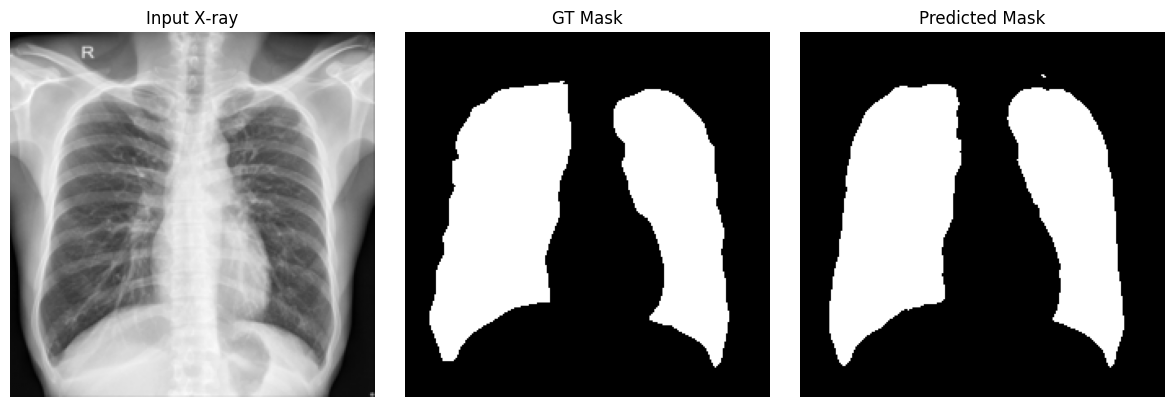

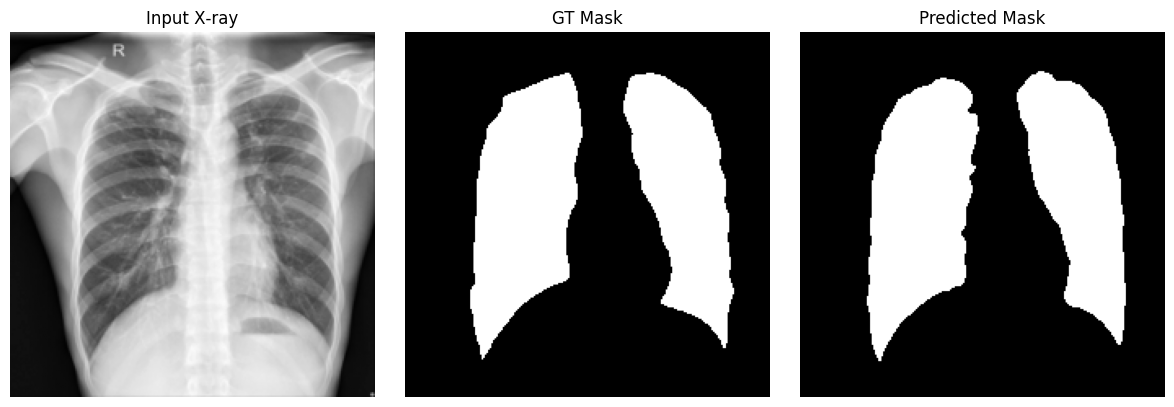

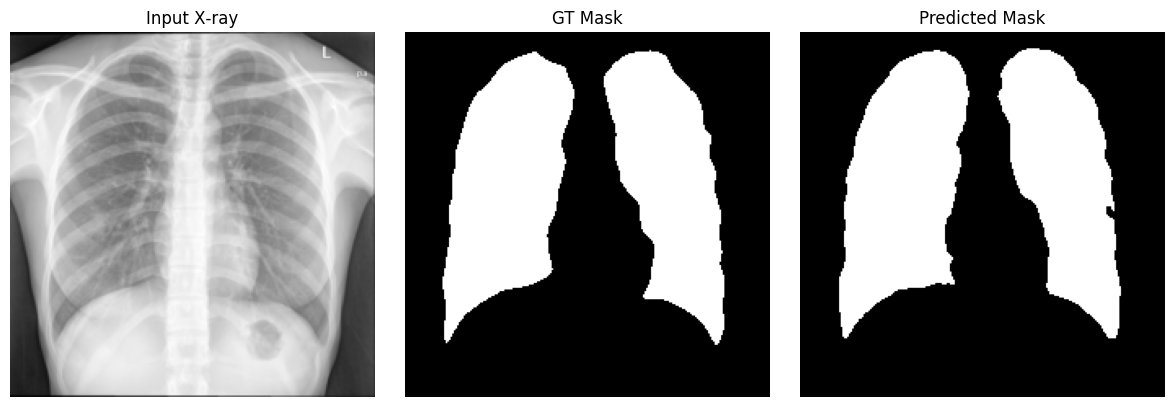

In [2]:
# === visualize_predictions.ipynb ===
import os, sys
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Path hack so we can import src/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.loader import NpySegDataset
from src.models.unet   import UNet

# 2) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) Load your best checkpoint
model = UNet(n_channels=1, n_classes=1).to(device)
ckpt  = os.path.join(PROJECT_ROOT, "results", "models", "unet_best_epoch3.pt")
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()

# 4) Prepare test loader
processed_root = os.path.join(PROJECT_ROOT, "data", "processed", "shenzhen")
test_ds = NpySegDataset(processed_root, split="test")
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=2)

# 5) Visualize 3 random samples
for _ in range(3):
    img, mask = next(iter(test_dl))      # img:[1,1,224,224], mask same
    with torch.no_grad():
        pred = torch.sigmoid(model(img.to(device))).cpu().numpy()[0,0]
    img_np  = img.numpy()[0,0]
    mask_np = mask.numpy()[0,0]

    # Plot
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img_np,  cmap="gray"); axes[0].set_title("Input X‑ray")
    axes[1].imshow(mask_np, cmap="gray"); axes[1].set_title("GT Mask")
    axes[2].imshow(pred>0.5, cmap="gray"); axes[2].set_title("Predicted Mask")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()